In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util 
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results.logs")
logger.propagate = False

from sklearn.preprocessing import StandardScaler

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")

split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(1100, 2252, 2) # Set wavelength range
pipeline_run_types = util.get_config_values("pipeline_run_types")

<h3 style="color: #eeaf23">Data Import, Split (85/15) and Visualization</h3>

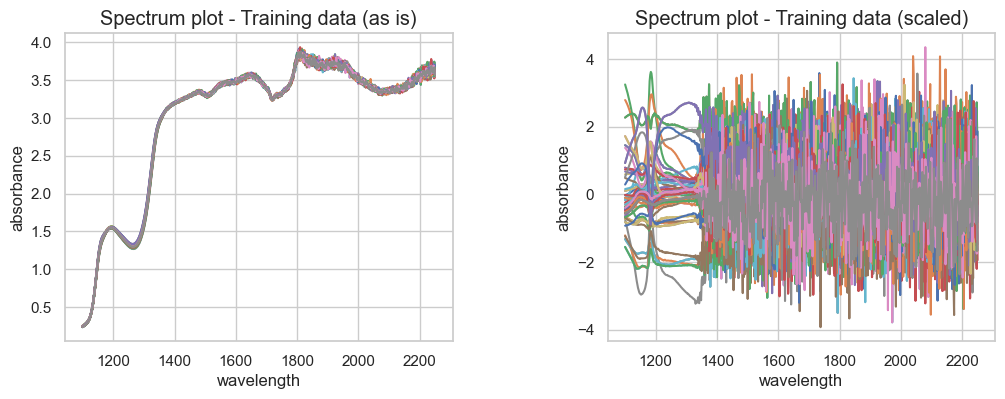

In [3]:
# for only one file - write dataset = files[index] (index maybe 0-3).
# For multiple files set value as list. e.g. - [files[0],files[2]]
# for all files, set dataset = files
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[0]), showDataEDA=False)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train,
    'title':'Spectrum plot - Training data (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_scaled,
    'title':'Spectrum plot - Training data (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #00faaa">Studying VIP for data</h3>

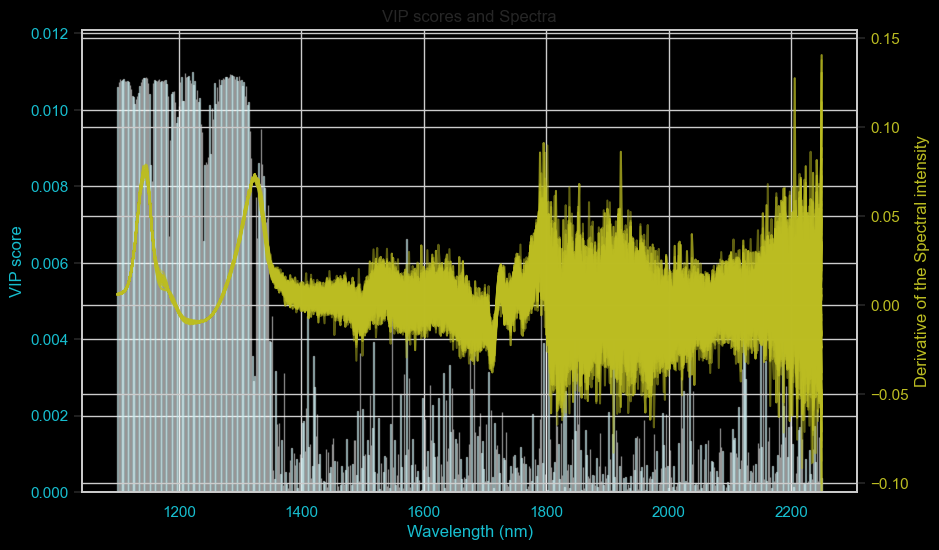

In [32]:
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

fulldata = pd.read_csv(dataset, sep=split_params['sep'])
X = fulldata.drop(axis=1, columns=split_params['drop_columns'])  # drop the y column
y = fulldata[split_params['y_data_column']]
X_diff = np.gradient(X, axis=1)
X_train_diff = np.gradient(X_train, axis=1)
X_test_diff = np.gradient(X_test, axis=1)

pls = PLSRegression(n_components=2)
pls.fit(X_train_diff, y_train)
# Predicting the test set results
y_pred_diff = pls.predict(X_test_diff)

# Get VIP scores
W = pls.x_weights_
T = pls.x_scores_
P = pls.x_loadings_
Q = pls.y_loadings_
V = np.dot(np.dot(P, np.diag(1/np.diag(np.dot(P.T, P)))), P.T)
V = np.dot(V, W)
s = np.diag(np.dot(np.dot(T.T, T), np.dot(W.T, W)))
s_vip = np.sqrt(len(s)*s/np.sum(s))
vip_scores = np.dot(V**2, s_vip)

# plot VIP scores and spectra on the same figure
fig, ax1 = plt.subplots(figsize=(10, 6), facecolor=(0,0,0))

# plot VIP scores
color = 'tab:cyan'
ax1.bar(wl, vip_scores, color=color, alpha=0.5)
ax1.set_xlabel('Wavelength (nm)', color=color)
ax1.set_ylabel('VIP score', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.set_ylim([0, max(vip_scores)*1.1])
ax1.set_facecolor((0,0,0))

# plot spectra
ax2 = ax1.twinx()
color = 'tab:olive'
for i in range(X_diff.shape[0]):
    ax2.plot(wl, X_diff[i, :], alpha=0.5, color=color)

ax2.set_ylabel('Derivative of the Spectral intensity', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([min(X_diff.flatten()), max(X_diff.flatten())*1.1])

plt.title('VIP scores and Spectra')
plt.show()

<h3 style="color: #00faaa">Cross Validation and Extrapolation</h3>

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Initialize PLS model
pls = PLSRegression(n_components=2)

# Perform cross-validation
cv_scores = cross_val_score(pls, X_train_diff, y_train, cv=5)


# Select just the first 150 entries of spectral intensities (from 1100 to 1400 nm)

X_red = fulldata.iloc[:, 1:151].values
X_red_diff = np.gradient(X_red, axis=1)
X_train_red_diff, X_test_red_diff, y_train, y_test = train_test_split(X_red_diff, y, test_size=0.3, random_state=42)
pls = PLSRegression(n_components=2)
pls.fit(X_train_red_diff, y_train)
cv_scores_red_diff = cross_val_score(pls, X_train_red_diff, y_train, cv=5)

# Predicting the test set results
y_pred_red_diff = pls.predict(X_test_red_diff)

r2_red_diff = r2_score(y_test, y_pred_red_diff)
mse_red_diff = mean_squared_error(y_test, y_pred_red_diff)

# Print average cross-validation score and standard deviation
print("Cross-validation score Differential Data: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

print("Cross-validation score Differential Data Reduced: %0.2f (+/- %0.2f)" % (cv_scores_red_diff.mean(), cv_scores_red_diff.std() * 2))
print('R-squared Reduced Data score:', r2_red_diff)
print('Mean Squared Reduced Data  Error:', mse_red_diff)

Cross-validation score Differential Data: 0.99 (+/- 0.01)
Cross-validation score Differential Data Reduced: 0.99 (+/- 0.01)
R-squared Reduced Data score: 0.9853413848221156
Mean Squared Reduced Data  Error: 0.06863102673071181


<h3 style="color: #00faaa">More Extrapolation with PLSR</h3>

INFO ************************************
INFO Pipeline Start [PLSR | EXTRAPOLATION]...
INFO Pipeline params :
INFO Data : data/beer_dataset.csv , Preprocessor : snv, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 6


INFO [MODEL EVALUATION]


[Model Evaluation] MSE value between y_test and y_pred : 0.083


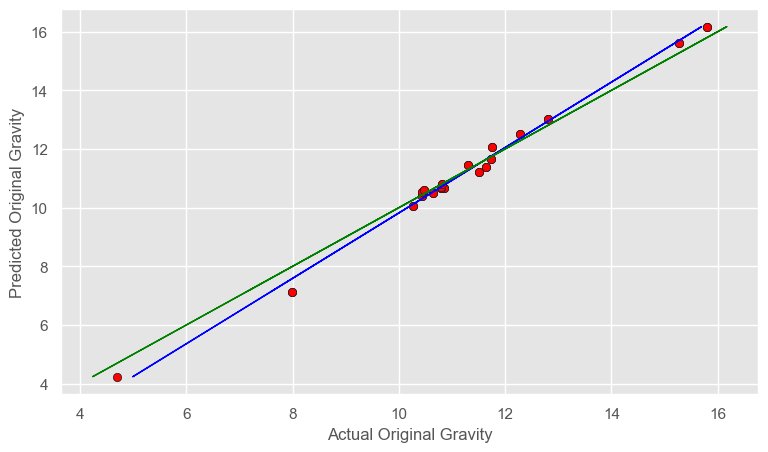

INFO Model loss : 0.08302104632876671
INFO Elapsed time for pipeline run : 1.71
INFO Pipeline end...
INFO ************************************


In [43]:
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting (Manual)
# read the file and create dataframe
import pandas as pd
data = pd.read_csv(dataset, sep=split_params['sep'])
X = data.drop(axis=1, columns=split_params['drop_columns'])  # drop the last column, so we have exactly 256 features
y = data[split_params['y_data_column']]

# Create X_train, X_test, y_train and y_test *** (BY INDICES) ***
split_ratio_train = 0.5
row_start_index_train, row_stop_index_train = 0, (split_ratio_train * X.shape[0])
row_start_index_test, row_stop_index_test = row_stop_index_train+1, X.shape[0]

X_train = X.iloc[int(row_start_index_train):int(row_stop_index_train),:]
y_train = y.iloc[int(row_start_index_train):int(row_stop_index_train)]
X_test = X.iloc[int(row_start_index_test):int(row_stop_index_test),:]
y_test = y.iloc[int(row_start_index_test):int(row_stop_index_test)]

# final data tuple
data = (X_train, X_test, y_train, y_test)

# Not required since we use only SNV and MSC for LASSO
preprocessor_params = {}

pipeline_params = {
    'logger' : logger,
    'data' : data,
    'validation-type' : validation_types[0],        # only KFolds
    'preprocessor' : preprocessors[3],              # only SNV
    'preprocessor-params' : preprocessor_params,
    'model' : models[0],                            # PLSR
    'evaluator' : evaluators[0],                    # MSE
    'pls_max_n_comp' : int(pls_max_n_comp),
    'folds' : int(folds),
    'wl' : wl,
    'plotting' : False,
    'showModelEvaluationPlots' : True,     # set to True to show final prediction line of best fit
    'pipeline_run_type' : pipeline_run_types[1]
}

start = timer()
logger.info("************************************")
logger.info("Pipeline Start [PLSR | EXTRAPOLATION]...")
logger.info("Pipeline params :")
logger.info("Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor'])
            + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", folds (for CV) : " + str(pipeline_params['folds']))
util.pipeline(pipeline_params)
end = timer()
logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
logger.info("Pipeline end...")
logger.info("************************************")

<h3 style="color: #00faaa">More Extrapolation with LASSO / RF / SVR</h3>

INFO ************************************
INFO Pipeline Start [PLSR | EXTRAPOLATION]...
INFO Pipeline params :
INFO Data : data/beer_dataset.csv , Preprocessor : snv, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 3
INFO [MODEL EVALUATION]




[Model Evaluation] MSE value between y_test and y_pred : 0.002


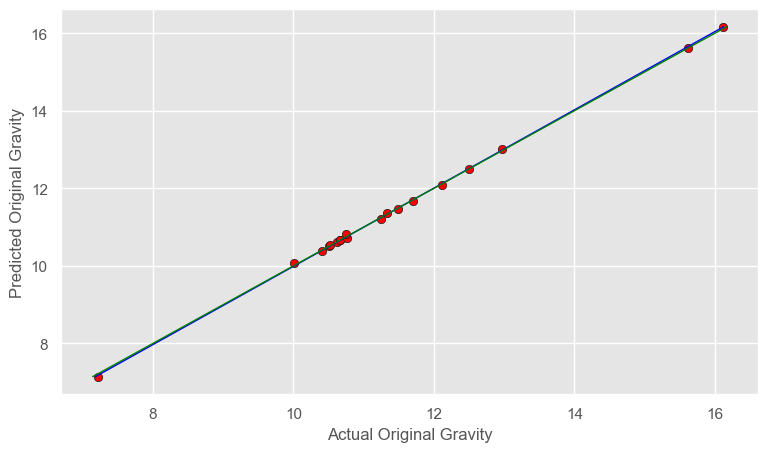

INFO Model loss : 0.0015261343232534856
INFO Elapsed time for pipeline run : 1.95
INFO Pipeline end...
INFO ************************************


In [56]:
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting (Manual)
# read the file and create dataframe
import pandas as pd
data = pd.read_csv(dataset, sep=split_params['sep'])
X = data.drop(axis=1, columns=split_params['drop_columns'])  # drop the last column, so we have exactly 256 features
y = data[split_params['y_data_column']]

alpha_range = np.linspace(0.01,500,1000, endpoint=False)

# Create X_train, X_test, y_train and y_test *** (BY INDICES) ***
split_ratio_train = 0.75
row_start_index_train, row_stop_index_train = 0, (split_ratio_train * X.shape[0])
row_start_index_test, row_stop_index_test = row_stop_index_train+1, X.shape[0]

X_train = X.iloc[int(row_start_index_train):int(row_stop_index_train),:]
y_train = y.iloc[int(row_start_index_train):int(row_stop_index_train)]
X_test = X.iloc[int(row_start_index_test):int(row_stop_index_test),:]
y_test = y.iloc[int(row_start_index_test):int(row_stop_index_test)]

# final data tuple
data = (X_train, X_test, y_train, y_test)

# Define custom param_grid for Grid Search CV
param_grid = {
    'kernel': ['poly'],
    'C': [50, 100, 200, 500, 1000],
    'epsilon': [0.1, 0.2, 0.5, 1]
}

pipeline_params = {
    'logger' : logger,
    'data' : data,
    'validation-type' : validation_types[0],        # only KFolds
    'preprocessor' : preprocessors[3],              # only SNV
    'preprocessor-params' : preprocessor_params,
    'model' : models[0],                            # LASSO
    'evaluator' : evaluators[0],                    # MSE
    'pls_max_n_comp' : int(pls_max_n_comp),
    'folds' : int(folds),
    'wl' : wl,
    'plotting' : False,
    'showModelEvaluationPlots' : True,     # set to True to show final prediction line of best fit
    'pipeline_run_type' : pipeline_run_types[1],
    'alpha_range' : alpha_range,
    'param_grid':param_grid
}

start = timer()
logger.info("************************************")
logger.info("Pipeline Start [PLSR | EXTRAPOLATION]...")
logger.info("Pipeline params :")
logger.info("Data : " + str(dataset) + " , Preprocessor : " + str(pipeline_params['preprocessor'])
            + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", folds (for CV) : " + str(pipeline_params['folds']))
util.pipeline(pipeline_params)
end = timer()
logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
logger.info("Pipeline end...")
logger.info("************************************")

<h3 style="color: #00faaa">Feature Selection and PCA with Random Forests</h3>

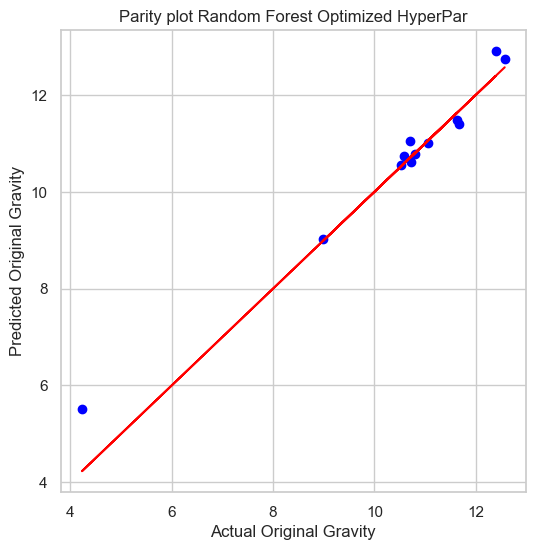

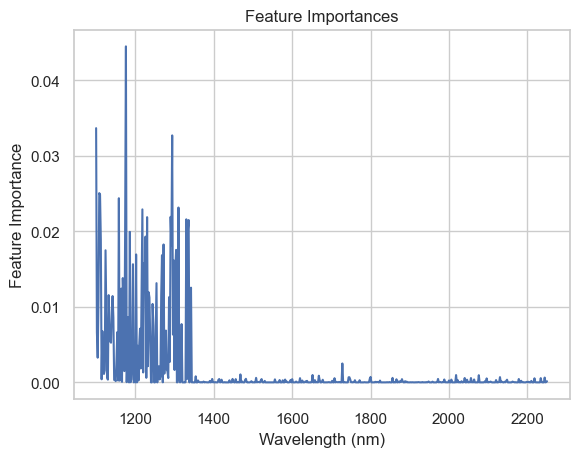

R-squared score All Features: 0.9873531634519042
Mean Squared Error All Features: 0.055443487625354
R-squared score Top Features: 0.9908158325945514
Mean Squared Error Top Features: 0.04026321285616955


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

fulldata = pd.read_csv(dataset, sep=split_params['sep'])
X = fulldata.drop(axis=1, columns=split_params['drop_columns'])  # drop the y column
y = fulldata[split_params['y_data_column']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_diff = np.gradient(X, axis=1)
X_train_diff = np.gradient(X_train, axis=1)
X_test_diff = np.gradient(X_test, axis=1)

# Fitting the PLS model with unprocessed data
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
# Predicting the test set results
y_pred = pls.predict(X_test)

# Fitting the PLS model with differential data
pls = PLSRegression(n_components=2)
pls.fit(X_train_diff, y_train)
# Predicting the test set results
y_pred_diff = pls.predict(X_test_diff)

r2_diff = r2_score(y_test, y_pred_diff)
mse_diff = mean_squared_error(y_test, y_pred_diff)

# Define the parameter grid for grid search
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt']}

# Create a random forest regressor object
rf = RandomForestRegressor()

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_diff, y_train.ravel())

# Print the best hyperparameters
# print('Best hyperparameters:', grid_search.best_params_)

# Use the best hyperparameters to fit the random forest model
rf = RandomForestRegressor(**grid_search.best_params_)
rf.fit(X_train_diff, y_train.ravel())

# Predicting the test set results
y_pred_diff_rf = rf.predict(X_test_diff)

# Plotting
# plot1_params = {
#     'x_axis_data' : wl,
#     'y_axis_data': X_train,
#     'title':'Spectrum plot - Training data (as is)',
#     'xlabel':'wavelength',
#     'ylabel':'absorbance'
# }
# plot2_params = {
#     'x_axis_data' : wl,
#     'y_axis_data': X_train_scaled,
#     'title':'Spectrum plot - Training data (scaled)',
#     'xlabel':'wavelength',
#     'ylabel':'absorbance'
# }
# util.dual_plot(plot1_params,plot2_params)

# plot parity plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_diff_rf, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot Random Forest Optimized HyperPar')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()

#Evaluating feature importance:
feat_importances = rf.feature_importances_
plt.plot(wl, feat_importances)
plt.title('Feature Importances')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Feature Importance')
plt.show()


##########
# TRAINING MODEL WITH SELECTED FEATURES

# Get indices of top n most important features
n = 50 # This parameter can be optimized
indices = np.argsort(feat_importances)[::-1][:n]
# Select only the columns corresponding to the top n features
X_top = X_diff[:, indices]

# Splitting the data into training and test sets
X_train_rf_red, X_test_rf_red, y_train, y_test = train_test_split(X_top, y, test_size=0.15, random_state=42)


# Use the best hyperparameters to fit the random forest model
rf = RandomForestRegressor(max_depth= 10, max_features= 'sqrt', min_samples_leaf=1, min_samples_split= 2, n_estimators=100, random_state=42)
rf.fit(X_train_rf_red, y_train.ravel())
# Make predictions
y_pred_rf_red = rf.predict(X_test_rf_red)

r2_diff_rf = r2_score(y_test, y_pred_diff_rf)
mse_diff_rf = mean_squared_error(y_test, y_pred_diff_rf)

print('R-squared score All Features:', r2_diff)
print('Mean Squared Error All Features:', mse_diff)

r2_rf_red = r2_score(y_test, y_pred_rf_red)
mse_rf_red = mean_squared_error(y_test, y_pred_rf_red)

print('R-squared score Top Features:', r2_rf_red)
print('Mean Squared Error Top Features:', mse_rf_red)